In [1]:
import sys
%load_ext autoreload
%autoreload 2

import logging
logging.basicConfig()

import bardensr
import tensorflow as tf
import matplotlib.pylab as plt
import collections
import numpy as np
import ray
import numpy.random as npr
import IPython.display
import os
import bardensr.registration.translations_tf
import bardensr.optimization.hvp_tf
import tqdm.notebook
import bardensr.plotting
import scipy as sp 
import skimage.feature
import scipy.spatial
import pkg_resources
import bardensr.misc
import bardensr.barcodediscovery
import bardensr.benchmarks
import dataclasses
import bardensr.spot_calling.barcodesfirst
import bardensr.preprocessing
import pygraphviz
import bardensr.spot_calling
import bardensr.optimization.cg_tf

# test cg

Without preconditioner

variance unexplained 3.9084361529585665e-07
resid 5.4309135479758615
resid 5.430913547976212
iters tf.Tensor(50, shape=(), dtype=int32)


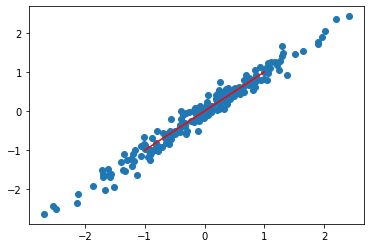

In [2]:
n=200

npr.seed(0)
A=npr.randn(n,n)
A=A@A.T

x_tru=npr.randn(n)
b=A@x_tru

A=tf.identity(A)
x_tru=tf.identity(x_tru)
b=tf.identity(b)

cgs=bardensr.optimization.cg_tf.cg(
    lambda x: tf.linalg.matvec(A,x),
    b,
    50,
)
est_x=cgs.x


print('variance unexplained',(tf.reduce_sum(cgs.r**2).numpy()/tf.reduce_sum(b**2)).numpy())
print('resid',tf.reduce_sum(cgs.r**2).numpy())
print('resid',tf.reduce_sum((tf.linalg.matvec(A,est_x)-b)**2).numpy())
print('iters',cgs.i)

plt.scatter(est_x.numpy(),x_tru.numpy())
plt.plot([-1,1],[-1,1],'r-')

with preconditioner

variance unexplained 4.219241272597632e-48
resid 5.862788515090349e-41
resid 1.934829675904713e-24
iters tf.Tensor(2, shape=(), dtype=int32)


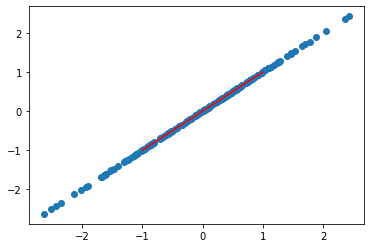

In [3]:

precond=np.linalg.inv(A.numpy())
precond=tf.identity(precond)

cgs=bardensr.optimization.cg_tf.cg(
    lambda x: tf.linalg.matvec(A,x),
    b,
    5,
    preconditioner=lambda x: tf.linalg.matvec(precond,x)
)

est_x=cgs.x

print('variance unexplained',(tf.reduce_sum(cgs.r**2).numpy()/tf.reduce_sum(b**2)).numpy())
print('resid',tf.reduce_sum(cgs.r**2).numpy())
print('resid',tf.reduce_sum((tf.linalg.matvec(A,est_x)-b)**2).numpy())
print('iters',cgs.i)

plt.scatter(est_x.numpy(),x_tru.numpy())
plt.plot([-1,1],[-1,1],'r-')

using initial condition (doesn't help much!)

variance unexplained 0.009439787867796508
resid 131169.27030374264
resid 131169.27030374284
iters tf.Tensor(50, shape=(), dtype=int32)


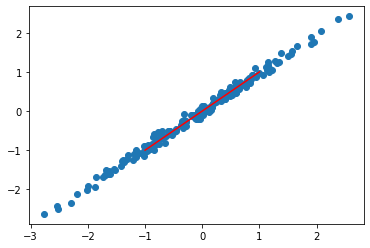

In [4]:
npr.seed(0)
x_guess=tf.identity(x_tru.numpy()+npr.randn(n)*.1)
cgs=bardensr.optimization.cg_tf.cg(
    lambda x: tf.linalg.matvec(A,x),
    b,
    50,
    x0=x_guess
)

est_x=cgs.x


print('variance unexplained',(tf.reduce_sum(cgs.r**2).numpy()/tf.reduce_sum(b**2)).numpy())
print('resid',tf.reduce_sum(cgs.r**2).numpy())
print('resid',tf.reduce_sum((tf.linalg.matvec(A,est_x)-b)**2).numpy())
print('iters',cgs.i)


plt.scatter(est_x.numpy(),x_tru.numpy())
plt.plot([-1,1],[-1,1],'r-')

getting an initial cgs (helps much more!)

variance unexplained 5.349949423300554e-08
resid 0.743394843024231
resid 0.7433948430241801
iters tf.Tensor(100, shape=(), dtype=int32)


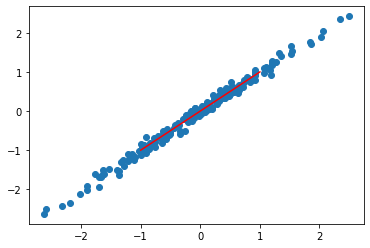

In [5]:
npr.seed(0)
cgs=bardensr.optimization.cg_tf.cg(lambda x: tf.linalg.matvec(A,x),b,50)
cgs=bardensr.optimization.cg_tf.cg_steps(cgs,lambda x: tf.linalg.matvec(A,x),50)

est_x=cgs.x

print('variance unexplained',(tf.reduce_sum(cgs.r**2).numpy()/tf.reduce_sum(b**2)).numpy())
print('resid',tf.reduce_sum(cgs.r**2).numpy())
print('resid',tf.reduce_sum((tf.linalg.matvec(A,est_x)-b)**2).numpy())
print('iters',cgs.i)


plt.scatter(est_x.numpy(),x_tru.numpy())
plt.plot([-1,1],[-1,1],'r-')

large, compiled

  0%|          | 0/5 [00:00<?, ?it/s]

tracing
variance unexplained 7.47906077061748e-11
resid 79.10921577464745
resid 79.10921577474667
iters tf.Tensor(500, shape=(), dtype=int32)


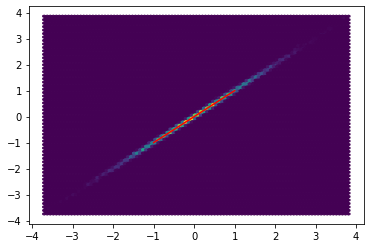

In [6]:
n=8000

npr.seed(0)
A=npr.randn(n,n)
A=A@A.T

x_tru=npr.randn(n)
b=A@x_tru

A=tf.identity(A)
x_tru=tf.identity(x_tru)
b=tf.identity(b)

TOTAL_ITERS_DESIRED=500
INNER_ITERS=100
OUTER_ITERS=TOTAL_ITERS_DESIRED//INNER_ITERS


@tf.function
def go(cgs):
    print('tracing')
    return bardensr.optimization.cg_tf.cg_steps(cgs,lambda x: tf.linalg.matvec(A,x),INNER_ITERS)

xs=[tf.identity(np.zeros(n))]

cgs=bardensr.optimization.cg_tf.initialize_cg(None,b)
for i in tqdm.notebook.trange(OUTER_ITERS):
    cgs=go(cgs)
    
est_x=cgs.x
print('variance unexplained',(tf.reduce_sum(cgs.r**2).numpy()/tf.reduce_sum(b**2)).numpy())
print('resid',tf.reduce_sum(cgs.r**2).numpy())
print('resid',tf.reduce_sum((tf.linalg.matvec(A,est_x)-b)**2).numpy())
print('iters',cgs.i)

plt.hexbin(est_x.numpy(),x_tru.numpy())
plt.plot([-1,1],[-1,1],'r-')

# deblurring examples

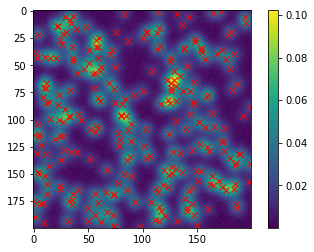

In [7]:
# create a blurred problem
npr.seed(1)
A=(npr.randn(200,200)>2.5).astype(float)*(npr.rand(200,200)*5+1.0)
Abl=bardensr.blur_kernels.gaussian_filter_2d(A,(5,5)).numpy() + npr.rand(200,200)*.005
Abl=np.clip(Abl,0,np.inf)
plt.imshow(Abl)
rows,cols=np.where(A)
plt.plot(cols,rows,'rx')
plt.colorbar()

Abl_tf=tf.identity(Abl)

### try CG

CG fails horribly!


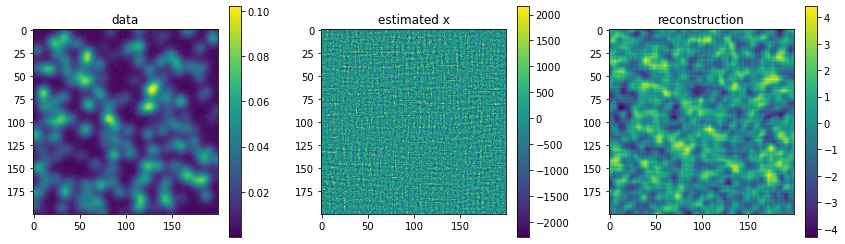

In [8]:
'''
try to solve min_x ||blur(x) - Abl||^2

  (doesn't work)
'''

cgs=bardensr.optimization.cg_tf.cg(
    lambda x: .0001*x+bardensr.blur_kernels.gaussian_filter_2d(x,tf.identity([5,5])),
    Abl_tf,
    50
)

print('CG fails horribly!')
with bardensr.plotting.AnimAcross() as a:
    a('data')
    a.cb(plt.imshow(Abl))
    
    a('estimated x')
    a.cb(plt.imshow(cgs.x.numpy()))
    
    a('reconstruction')
    recon=bardensr.blur_kernels.gaussian_filter_2d(cgs.x,(5,5)).numpy()
    a.cb(plt.imshow(recon))

### what if we enforce positivity?

In [9]:
'''
try to solve 

    min   ||blur(x)-Abl||^2 - lam*||x||_1
    s.t.  x >=0
          
'''


@tf.function
def loss(x,target,lam):
    blurx   = bardensr.blur_kernels.gaussian_filter_2d(x,tf.identity([5,5]))
    return tf.reduce_mean((blurx-target)**2) + lam*tf.reduce_sum(x)
    
    
@tf.function
def setup_ap_with_newton(x,target,lam,maxiter):
    sd=bardensr.optimization.hvp_tf.inexact_newton_solve_with_bounds(
        lambda x:loss(x,target,lam),
        x,
        maxiter=maxiter,
        lo=0
    )
    
    return bardensr.optimization.hvp_tf.prepare_for_armijo_linesearch(
        lambda x: loss(x,target,lam),
        x,
        lo=0.0,
        search_direction=sd
    )

@tf.function
def setup_ap_without_newton(x,target,lam):
    return bardensr.optimization.hvp_tf.prepare_for_armijo_linesearch(
        lambda x: loss(x,target,lam),
        x,
        lo=0.0,
    )


In [10]:


# initial condition
x=tf.identity(np.zeros(A.shape))

# lambda
lam=tf.cast(0,x.dtype)

# target
target = Abl_tf

# loop
losses=[loss(x,target,lam).numpy()]
tq=tqdm.notebook.trange(20)
for i in tq:
    ap=setup_ap_with_newton(x,target,lam,tf.identity(20))
    x,newloss,armijo,i=bardensr.optimization.hvp_tf.armijo_linesearch(
        lambda x: loss(x,target,lam),
        ap,
        maxiter=10
    )
    losses.append(loss(x,target,lam).numpy())
    tq.set_description(f'{losses[-1]:.4e}')
    

tq=tqdm.notebook.trange(500)
for i in tq:
    ap=setup_ap_without_newton(x,target,lam)
    x,newloss,armijo,i=bardensr.optimization.hvp_tf.armijo_linesearch(
        lambda x: loss(x,target,lam),
        ap,
        maxiter=10
    )
    losses.append(loss(x,target,lam).numpy())
    tq.set_description(f'{losses[-1]:.4e}')
        
        
print(losses[-1])

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

2.0440601405260476e-06


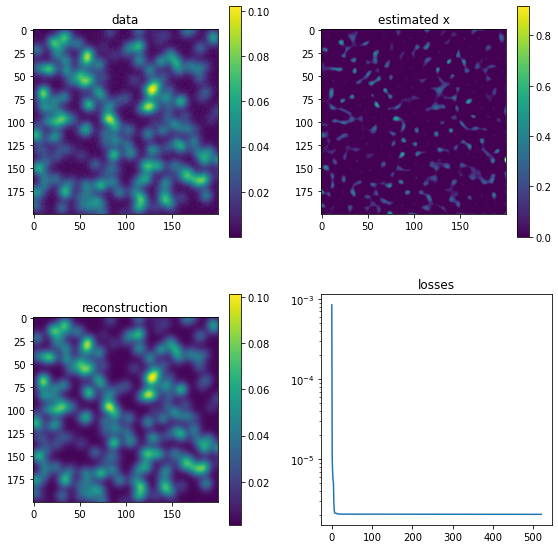

In [11]:
with bardensr.plotting.AnimAcross() as a:
    a('data')
    a.cb(plt.imshow(Abl))
    
    a('estimated x')
    a.cb(plt.imshow(x))
    
    a('reconstruction')
    recon=bardensr.blur_kernels.gaussian_filter_2d(x,(5,5)).numpy()
    a.cb(plt.imshow(recon))
    
    a('losses')
    plt.plot(losses)
    plt.gca().set_yscale('log')

Text(0, 0.5, 'original')

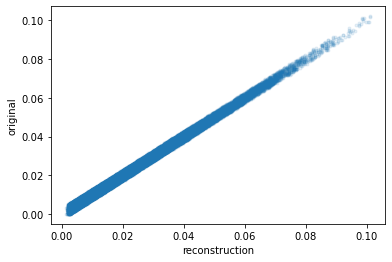

In [12]:
plt.plot(recon.ravel(),Abl.ravel(),'.',alpha=.1)
plt.xlabel("reconstruction")
plt.ylabel("original")